Put this in this file to have imported models reload automatically when you edit them.

In [19]:
!cat ~/.ipython/profile_default/startup/00-autoreload.ipy

%load_ext autoreload
%autoreload 2


# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# pytorch datasets that download MNIST set as needed; used only to download files
train_dset = dsets.MNIST(root=data_path, download=False, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=False, train=False, transform=trans)

In [3]:
# this is a hacky way of turning a dataset into two lists.
# In this case, Xtest is now a list of Tensors, and ytest is a regular list
Xtest, ytest = list(zip(*test_dset))

In [4]:
# This turns a list of N A*B tensors into an N*A*B tensor
Xtest = torch.stack(Xtest)

In [5]:
# This turns a list into a tensor, and ensures they stay as integers (no conversion to floats!)
ytest = torch.LongTensor(ytest)

In [6]:
from torch.utils.data import DataLoader

batch_size = 128

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [7]:
import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [8]:
model = MLPNet()

learning_rate = 1e-1
num_epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # no momentum for like-with-like momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):

    for batch_idx, (x, target) in enumerate(train_dloader):
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target)
        train_loss_history.append(loss.item())
        if batch_idx%100 == 0:
            print(batch_idx, train_loss_history[-1])
        loss.backward()
        optimizer.step()
    
    # only do this once per epoch. Expensive.
    # (Although it makes it difficult to show two loss curves on same plot, as you saw)
    with torch.no_grad():
        test_loss_history.append(criterion(model(Xtest), ytest).item())
        print("-->", epoch, test_loss_history[-1])

0 2.2997732162475586
100 0.9658642411231995
200 0.6384410858154297
300 0.4885415732860565
400 0.34330153465270996
--> 0 0.32315945625305176
0 0.27585044503211975
100 0.18341147899627686
200 0.2150757610797882
300 0.4083252549171448
400 0.29769498109817505
--> 1 0.21210375428199768
0 0.2777971625328064
100 0.19314226508140564
200 0.13202005624771118
300 0.12300673872232437
400 0.21683062613010406
--> 2 0.16824617981910706
0 0.30648213624954224
100 0.18518926203250885
200 0.22343380749225616
300 0.14932726323604584
400 0.19650715589523315
--> 3 0.1449524164199829
0 0.0770709291100502
100 0.08593206852674484
200 0.11101403832435608
300 0.12402833253145218
400 0.10719337314367294
--> 4 0.1389201432466507


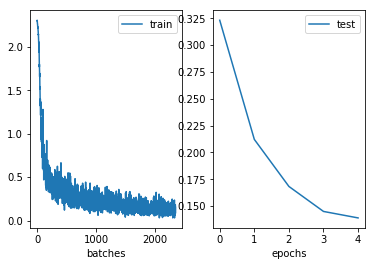

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].plot(train_loss_history, label="train")
ax[0].set_xlabel("batches")
ax[1].plot(test_loss_history, label="test")
ax[1].set_xlabel("epochs")
ax[0].legend()
ax[1].legend();

## Testing Federation

In [15]:
import federated

def make_model():
    return MLPNet()

manager = federated.FederatedManager(
    [train_dloader],
    make_model,
    nn.CrossEntropyLoss(),  # this needs to be an instance of the class, i.e. an object, i.e. you needed `()`
    Xtest,
    ytest,
)

In [16]:
# compare like with like
for w in manager.workers:
    w.lr = learning_rate

In [17]:
for i in range(num_epochs):
    manager.round()
    print("-->", i, manager.manager_loss_history[-1])

0 2.3039159774780273
100 0.738369345664978
200 0.5175963044166565
300 0.46021562814712524
400 0.2818622589111328
--> 0 0.3078147768974304
0 0.42502671480178833
100 0.21099109947681427
200 0.20319485664367676
300 0.24987225234508514
400 0.2506459057331085
--> 1 0.22224541008472443
0 0.22429701685905457
100 0.15013852715492249
200 0.28139403462409973
300 0.125340074300766
400 0.22222980856895447
--> 2 0.1751822531223297
0 0.2659588158130646
100 0.15020017325878143
200 0.2074354588985443
300 0.23879790306091309
400 0.11009503155946732
--> 3 0.140364870429039
0 0.15712079405784607
100 0.1282908022403717
200 0.2205338478088379
300 0.09678976982831955
400 0.1541793793439865
--> 4 0.1313612461090088


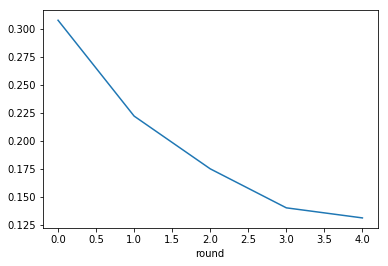

In [18]:
fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2])
ax.set_xlabel("round");

# Next

 - $>1$ dataloader to federated
 - visualize evolution of manager.workers[0, 1, 2, etc.].loss_history (this should be comparable to the training loss on the non-federated model)
 - stack deck in dataloaders